# Interpretable Complex-Valued Neural Networks for Privacy Protection

[[GitHub](https://github.com/romech/fact-ai)] [[Original Paper](https://iclr.cc/virtual/poster_S1xFl64tDr.html)]

## Contents
1. Classification Experiments
2. Inversion Attacks
3. Inference Attacks



## Setup

In [17]:
import pandas as pd
import pytorch_lightning as pl
import torch
from src.dataset import CIFAR10DataModule, CIFAR100DataModule, CIFAR100Super
from src.model_classifier import BaselineModel, ComplexModel
from src.model_inversion_attack import AngleInversionModel, FeatureInversionAngleModel, FeatureInversionModel
from src.model_inference_attack import InferenceAttack1Model, InferenceAttack2Model, InferenceAttack3Model
import os
from collections import defaultdict, OrderedDict
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision.utils import make_grid, save_image
sns.set()
from eval_utils import *

In [2]:
trainer = pl.Trainer(gpus=int(torch.cuda.is_available()), progress_bar_refresh_rate=0, weights_summary=False, 
                     benchmark=True, logger=False, checkpoint_callback=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [3]:
data_path = "data"

In [4]:
datamodules = {
    "CIFAR-10": CIFAR10DataModule(128, data_path, 0),
    "CIFAR-100": CIFAR100DataModule(128, data_path, 0),
    "CIFAR-100 Super": CIFAR100DataModule(128, data_path, 0, superclass=True)
}

## 1 Classification Experiments

### 1.1 ResNets on CIFAR-10 (Table 1)

In [5]:
%%capture
results = defaultdict(OrderedDict)

for arch, experiments in resnet_classification_experiments.items():
    for e, file in experiments.items():
        pl.seed_everything(0)
        if e == "Complex":
            model = ComplexModel.load_from_checkpoint(os.path.join(classification_path, file))
        else:
            model = BaselineModel.load_from_checkpoint(os.path.join(classification_path, file))
            
        out = trainer.test(model, datamodule=datamodules["CIFAR-10"])
        
        results[arch][e] = round((1 - out[0]['test_acc']) * 100, 2)

In [6]:
print('CLASSIFICATION ERROR RATES')
pd.DataFrame(results).T

CLASSIFICATION ERROR RATES


,Original,Additional,Complex
ResNet-20-a,7.77,9.06,11.88
ResNet-20-b,8.03,8.30,13.13
ResNet-32-a,7.27,8.95,11.27
ResNet-32-b,7.22,8.88,10.56
ResNet-44-a,6.57,9.32,10.02
ResNet-44-b,7.31,8.84,10.14
ResNet-56-a,7.19,8.45,10.03
ResNet-56-b,6.89,8.27,9.78


### 1.2 ResNet-56 + LeNet on CIFAR-10 and CIFAR-100 (Table 2)

In [27]:
%%capture
results = defaultdict(OrderedDict)

for (arch, ds), experiments in mixed_classification_experiments.items():
    for e, file in experiments.items():
        pl.seed_everything(0)
        if e == "Complex":
            model = ComplexModel.load_from_checkpoint(os.path.join(classification_path, file))
        else:
            model = BaselineModel.load_from_checkpoint(os.path.join(classification_path, file))
            
        out = trainer.test(model, datamodule=datamodules[ds])
        
        results[(arch, ds)][e] = round((1 - out[0]['test_acc']) * 100, 2)

In [33]:
print('CLASSIFICATION ERROR RATES')
pd.DataFrame(results).T

CLASSIFICATION ERROR RATES


Original  Additional  Noisy (gamma = 0.2)  \
LeNet       CIFAR-10      26.09       26.38                26.73   
            CIFAR-100     60.89       60.34                61.55   
ResNet-56-a CIFAR-100     32.20       32.46                32.67   

                       Noisy (gamma = 0.5)  Noisy (gamma = 1.0)  Complex  
LeNet       CIFAR-10                 29.17                34.98    33.84  
            CIFAR-100                64.69                66.83    74.32  
ResNet-56-a CIFAR-100                33.58                33.91    35.30

## 2 Inversion Attacks

### 2.1 Angle Estimation on CIFAR-10 (Table 3)

In [44]:
%%capture
results = defaultdict(OrderedDict)

for (arch, ds), file in angle_estimation_experiments.items():
    pl.seed_everything(0)
    model = AngleInversionModel.load_from_checkpoint(os.path.join(angle_estimation_path, file))

    out = trainer.test(model, datamodule=datamodules[ds])
        
    results[(arch, ds)]["MAE"] = round(out[0]['test_mae'], 4)

In [45]:
print('MAE')
pd.DataFrame(results).T

CLASSIFICATION ERROR RATES


MAE
ResNet-20-a CIFAR-10   0.0842
ResNet-20-b CIFAR-10   0.0884
ResNet-32-a CIFAR-10   0.0875
ResNet-32-b CIFAR-10   0.0874
ResNet-44-a CIFAR-10   0.0817
ResNet-44-b CIFAR-10   0.0895
ResNet-56-a CIFAR-10   0.0839
ResNet-56-b CIFAR-10   0.0846
LeNet       CIFAR-10   0.2371
            CIFAR-100  0.3178
ResNet-56-a CIFAR-100  0.0812

### 2.2 Reconstructing ResNet Inputs on CIFAR-10 (Table 4)

In [51]:
%%capture
results = defaultdict(OrderedDict)

for arch, experiments in resnet_inversion_experiments.items():
    for e, file in experiments.items():
        pl.seed_everything(0)
        if e == "Complex dec(a*)":
            model = FeatureInversionAngleModel.load_from_checkpoint(os.path.join(inv_attack1_path, file))
        else:
            model = FeatureInversionModel.load_from_checkpoint(os.path.join(inv_attack2_path, file))
            
        out = trainer.test(model, datamodule=datamodules["CIFAR-10"])
        
        results[arch][e] = round(out[0]['test_mae'], 4)

In [52]:
print('RECONSTRUCTION ERRORS')
pd.DataFrame(results).T

CLASSIFICATION ERROR RATES


,Original,Additional,Complex dec(a*),Complex dec(x)
ResNet-20-a,0.0750,0.1003,0.1904,0.2382
ResNet-20-b,0.0807,0.1009,0.2268,0.2865
ResNet-32-a,0.0927,0.1872,0.1931,0.2544
ResNet-32-b,0.0748,0.2201,0.2050,0.2678
ResNet-44-a,0.0735,0.2132,0.2219,0.2880
ResNet-44-b,0.0642,0.2192,0.2261,0.2994
ResNet-56-a,0.0581,0.0866,0.2092,0.2832
ResNet-56-b,0.0582,0.0935,0.2459,0.3413


### 2.3 Reconstructing ResNet + LeNet Inputs on CIFAR-10 and CIFAR-100 (Table 5)

In [60]:
%%capture
results = defaultdict(OrderedDict)

for (arch, ds), experiments in mixed_inversion_experiments.items():
    for e, file in experiments.items():
        pl.seed_everything(0)
        if e == "Complex dec(a*)":
            model = FeatureInversionAngleModel.load_from_checkpoint(os.path.join(inv_attack1_path, file))
        else:
            model = FeatureInversionModel.load_from_checkpoint(os.path.join(inv_attack2_path, file))
            
        out = trainer.test(model, datamodule=datamodules[ds])
        
        results[(arch, ds)][e] = round(out[0]['test_mae'], 4)

In [61]:
print('RECONSTRUCTION ERROS')
pd.DataFrame(results).T

CLASSIFICATION ERROR RATES


Original  Additional  Noisy (gamma = 0.2)  \
LeNet       CIFAR-10     0.2070      0.2465               0.2108   
            CIFAR-100    0.1698      0.2374               0.2000   
ResNet-56-a CIFAR-100    0.0830      0.0955               0.1005   

                       Noisy (gamma = 0.5)  Noisy (gamma = 1.0)  \
LeNet       CIFAR-10                0.2421               0.3637   
            CIFAR-100               0.2042               0.2527   
ResNet-56-a CIFAR-100               0.1280               0.1489   

                       Complex dec(a*)  Complex dec(x)  
LeNet       CIFAR-10            0.4285          0.4423  
            CIFAR-100           0.2836          0.2497  
ResNet-56-a CIFAR-100           0.1517          0.2135

### 2.4 Visualization of Reconstructed Images

In [30]:
datamodules["CIFAR-10"].setup("test")
cif10_inputs, _ = next(iter(datamodules["CIFAR-10"].test_dataloader()))

datamodules["CIFAR-100"].setup("test")
cif100_inputs, _ = next(iter(datamodules["CIFAR-100"].test_dataloader()))

inputs = {
    "CIFAR-10": cif10_inputs,
    "CIFAR-100": cif100_inputs,
}

In [31]:
%%capture
results = {}

with torch.no_grad():
    for k, experiments in mixed_inversion_experiments.items():
        results[k] = [inputs[k[1]][:9]]
        for e, file in experiments.items():
            pl.seed_everything(0)
            if e == "Complex dec(a*)":
                model = FeatureInversionAngleModel.load_from_checkpoint(os.path.join(inv_attack1_path, file))
            else:
                model = FeatureInversionModel.load_from_checkpoint(os.path.join(inv_attack2_path, file))

            model.eval()
            out = model(inputs[k[1]])

            results[k].append(out[:9])

In [32]:
for k, v in results.items():
    results[k] = torch.cat(v)

In [50]:
def plot_grid(images, title, n_row):
    grid = make_grid(images, n_row)
    plt.figure(figsize=(20, 10))
    plt.grid(False)
    plt.title(title)
    plt.xticks([])
    plt.yticks(np.arange(18, 300, 34),
              ["Input", "Original", "Additional", r"Noisy ($\gamma = 0.2$)", r"Noisy ($\gamma = 0.5$)", 
               r"Noisy ($\gamma = 1.0$)", "Complex dec(a*)", "Complex dec(x)"])
    plt.imshow(inverse_normalize(grid).permute(1, 2, 0))
    plt.show()

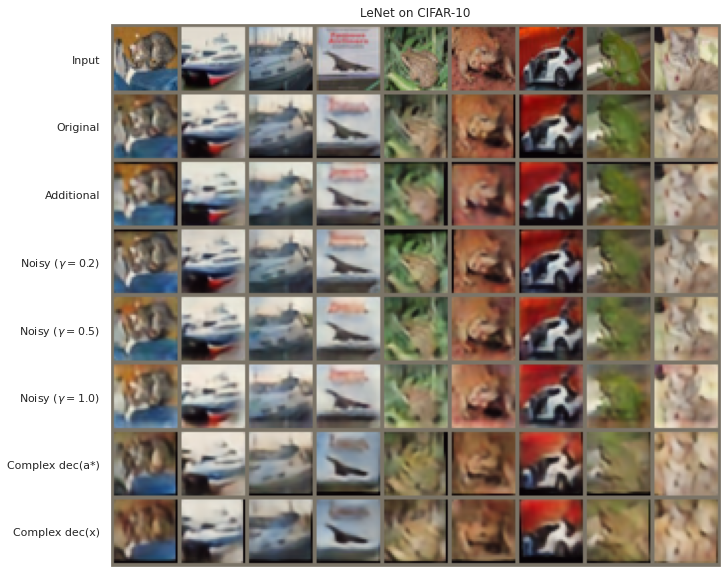

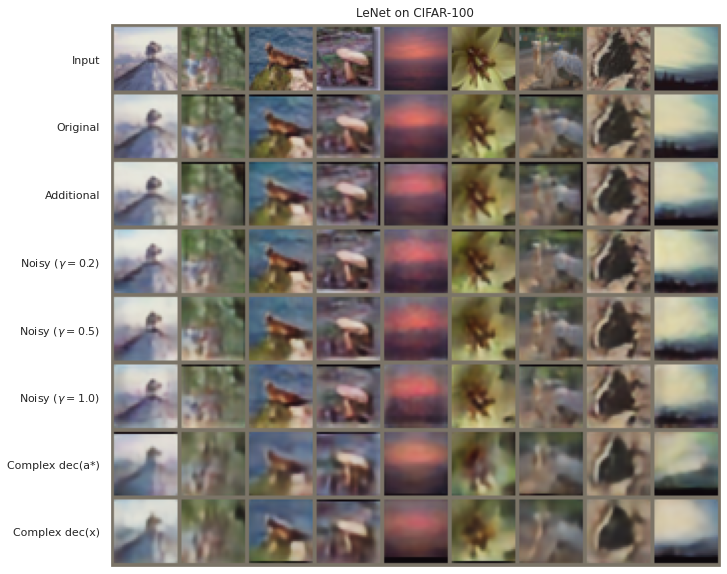

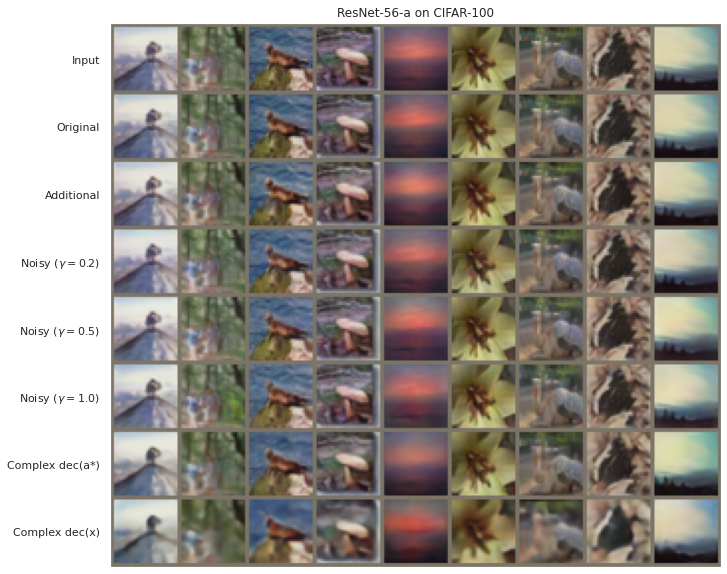

In [52]:
for k, v in results.items():
    plot_grid(v, k[0] + " on " + k[1], 9)

## 3 Inference Attacks

### 3.1 Inference Attack 1 (Figure 1a)

In [65]:
ckpt_files = [f for f in os.listdir("inference_attacks/resnet_56_attacker") if ".ckpt" in f]
ckpt_files.sort(key=lambda x: int(re.findall("\d+", x)[0]))

In [67]:
complex_history = []
additional_history = []
raw_history = []

In [69]:
%%capture
for f in ckpt_files:
    pl.seed_everything(0)
    complex_model = InferenceAttack1Model(os.path.join("inference_attacks/resnet_56_attacker", f), 
                                          complex_prototype_file, complex_inv_model_file, 
                                          datamodules["CIFAR-100"].dims, complex=True, 
                                          angle_dis_weights=angle_estimator_file)
    complex_result = trainer.test(complex_model, datamodule=datamodules["CIFAR-100"])
    complex_history.append(complex_result[0]["test_acc"])
    
    pl.seed_everything(0)
    additional_model = InferenceAttack1Model(os.path.join("inference_attacks/resnet_56_attacker", f), 
                                             additional_prototype_file, additional_inv_model_file, 
                                             datamodules["CIFAR-100"].dims)
    additional_result = trainer.test(additional_model, datamodule=datamodules["CIFAR-100"])
    additional_history.append(additional_result[0]["test_acc"])
    
    pl.seed_everything(0)
    raw_model = BaselineModel.load_from_checkpoint(os.path.join("inference_attacks/resnet_56_attacker", f))
    raw_result = trainer.test(raw_model, datamodule=datamodules["CIFAR-100"])
    raw_history.append(raw_result[0]["test_acc"])

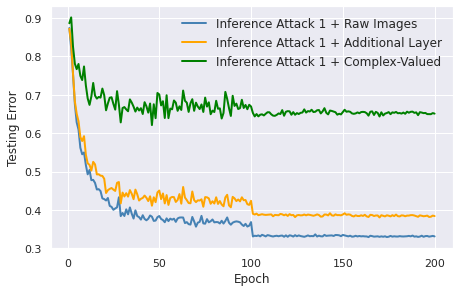

In [72]:
plt.figure(figsize=(7.2, 4.45))
plt.plot(np.arange(1, 201), 1 - np.array(raw_history), label="Inference Attack 1 + Raw Images", linewidth=2, c="steelblue")
plt.plot(np.arange(1, 201), 1 - np.array(additional_history), label="Inference Attack 1 + Additional Layer", linewidth=2, c="orange")
plt.plot(np.arange(1, 201), 1 - np.array(complex_history), label="Inference Attack 1 + Complex-Valued", linewidth=2, c="green")
plt.xticks([0, 50, 100, 150, 200])
plt.yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.xlabel("Epoch")
plt.ylabel("Testing Error")
plt.legend(frameon=False, loc="best", fontsize="medium")
plt.show()

### 3.1 Inference Attack 2 + 3 (Figure 1b)

For this part, we only show the classification error of the last epoch since exact reproduction of the plots would require to train the models from scratch, which takes multiple hours.

In [107]:
%%capture
pl.seed_everything(0)
model = InferenceAttack2Model.load_from_checkpoint(os.path.join(inf_attack_path, inf_attack2_additional_path))
result = trainer.test(model, datamodule=datamodules["CIFAR-100"])

In [108]:
print("Final classification error of inference attack 2 for baseline with additional layer:", round(1 - result[0]["test_acc"], 4))

Final classification error of inference attack 2 for baseline with additional layer: 0.332


In [109]:
%%capture
pl.seed_everything(0)
model = InferenceAttack2Model.load_from_checkpoint(os.path.join(inf_attack_path, inf_attack2_complex_path))
result = trainer.test(model, datamodule=datamodules["CIFAR-100"])

In [110]:
print("Final classification error of inference attack 2 for complex network:", round(1 - result[0]["test_acc"], 4))

Final classification error of inference attack 2 for complex network: 0.4144


In [111]:
%%capture
pl.seed_everything(0)
model = InferenceAttack3Model.load_from_checkpoint(os.path.join(inf_attack_path, inf_attack3_additional_path))
result = trainer.test(model, datamodule=datamodules["CIFAR-100"])

In [112]:
print("Final classification error of inference attack 3 for baseline with additional layer:", round(1 - result[0]["test_acc"], 4))

Final classification error of inference attack 3 for baseline with additional layer: 0.356


In [104]:
%%capture
pl.seed_everything(0)
model = InferenceAttack3Model.load_from_checkpoint(os.path.join(inf_attack_path, inf_attack3_complex_path))
result = trainer.test(model, datamodule=datamodules["CIFAR-100"])

In [105]:
print("Final classification error of inference attack 3 for complex network:", round(1 - result[0]["test_acc"], 4))

Final classification error of inference attack 3 for complex network: 0.432
